# VNTR Copy Number Variation

In [1]:
# Import packages.
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats as stats
# Print version numbers.
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)

matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2
scipy 1.8.0


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.facecolor': 'white',
    'font.family': 'serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
})
# Intialize the pandas preferences.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load the meta data file for the TGP.
tgp_df = pd.read_csv(
    '../meta_data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Intialize the tgp pop list.
tgp_pop_list = [
    'LWK', 'GWD', 'MSL', 'ESN', 'YRI', # AFR.
    'BEB', 'STU', 'ITU', 'PJL', 'GIH', # SAS.
    'CHB', 'KHV', 'CHS', 'JPT', 'CDX', # EAS.    
    'TSI', 'CEU', 'IBS', 'GBR', 'FIN', # EUR.
    'PEL', 'MXL', 'CLM', 'PUR', # AMR.
]
tgp_spop_list = ['AFR', 'SAS', 'EAS', 'EUR', 'AMR']

In [4]:
# Intialize dictionaries of tgp individuals haplotype identity.
het_hom_int_72kb = {
    'HET': np.loadtxt('../meta_data/72kb_all_het_int_idx.csv', delimiter=',', dtype=int),
    'HOM': np.loadtxt('../meta_data/72kb_all_hom_int_idx.csv', delimiter=',', dtype=int),
    'REC': np.loadtxt('../meta_data/72kb_all_rec_int_idx.csv', delimiter=',', dtype=int),
}

## Short-Read Data

In [5]:
# Load in the repeats dataframe.
repeats_df = pd.read_csv('../meta_data/hg38_muc19_short_read_repeats.csv')

In [6]:
# Extract the individual arrays.
repeat_inds = repeats_df['Individual'].values
tgp_inds = tgp_df['IND'].values
# Intialize a haplotype list column.
hap_col = []
# For every repeat individual...
for ind in repeat_inds: 
    # Determine the index.
    ind_idx = np.where(tgp_inds == ind)[0]
    # If the individual is not an ACB or ASW individual...
    if ind_idx.size > 0:
        # Determine the haplotype.
        if ind_idx[0] in het_hom_int_72kb['HET']:
            hap_col.append('HET')
        elif ind_idx[0] in het_hom_int_72kb['HOM']:
            hap_col.append('HOM')
        elif ind_idx[0] in het_hom_int_72kb['REC']:
            hap_col.append('REC')
        else:
            hap_col.append('HUM')
    else:
        hap_col.append('RMV')
# Append the column.
repeats_df['HAP'] = hap_col
# Filter out ACB and ASW.
hap_repeats_df = repeats_df[repeats_df['HAP'] != 'RMV']

In [7]:
# Show the mean number of repeats per super population.
hap_repeats_df.groupby('Super Population').mean().sort_values('Repeat Counts')

,Repeat Counts
Super Population,
AFR,345.119284
SAS,351.713701
EUR,351.796813
EAS,355.080000
AMR,416.662824


In [8]:
# Show the mean number of repeats per population.
hap_repeats_df.groupby('Population').mean().sort_values('Repeat Counts')

,Repeat Counts
Population,
LWK,340.707071
GWD,341.725664
FIN,341.898990
MSL,343.529412
CHB,345.108911
BEB,347.372093
GBR,348.186813
ESN,349.091837
STU,349.823529


In [9]:
# Subset dataframes.
non_afr_repeats = hap_repeats_df[hap_repeats_df['Super Population'] != 'AFR']
eurasia_reapeats = non_afr_repeats[non_afr_repeats['Super Population'] != 'AMR']
amr_reapeats = non_afr_repeats[non_afr_repeats['Super Population'] == 'AMR']
mxl_reapeats = non_afr_repeats[non_afr_repeats['Population'] == 'MXL']
# Find the means.
non_afr_mean = non_afr_repeats['Repeat Counts'].mean()
eurasia_mean = eurasia_reapeats['Repeat Counts'].mean()
# Build the contigency table.
amr_fet_table = [
    [(amr_reapeats['Repeat Counts'].values >= non_afr_mean).sum(),
    (amr_reapeats['Repeat Counts'].values < non_afr_mean).sum()],
    [(eurasia_reapeats['Repeat Counts'].values >= non_afr_mean).sum(),
    (eurasia_reapeats['Repeat Counts'].values < non_afr_mean).sum()]
]
# Perform a fishers exact test.
amr_or, amr_pval = stats.fisher_exact(amr_fet_table, alternative='greater')

In [10]:
# Intialize a dictionary.
df_dicc = {
    'Population': ['Admixed American', 'Non-African'],
    r'Num. of Inds. $>=$ Mean Repeat Count': [amr_fet_table[0][0], amr_fet_table[1][0]],
    r'Num. of Inds. $<$ Mean Repeat Count': [amr_fet_table[0][1], amr_fet_table[1][1]],
}
# Convert to a dataframe.
fet_df = pd.DataFrame(df_dicc)
# Export the dataframe.
#fet_df.to_csv('./dataframes/tgp_muc19_vntr_fet.csv', index=False)
# Print the results of the fishers exact test.
print('OR:', amr_or)
print('P-value:', amr_pval)
print('Non-AFR Mean:', non_afr_mean)
# Show the results of the fishers exact test.
fet_df

OR: 2.2018819503849443
P-value: 4.9755822988599555e-11
Non-AFR Mean: 364.9140369967356


,Population,Num. of Inds. $>=$ Mean Repeat Count,Num. of Inds. $<$ Mean Repeat Count
0,Admixed American,180,167
1,Non-African,490,1001


In [11]:
# Intialize MXL haplotype conditions.
den_cond = (mxl_reapeats['HAP'] == 'HOM') | (mxl_reapeats['HAP'] == 'HET')
hum_cond = mxl_reapeats['HAP'] == 'HUM'
# Compute the mean for MXL.
mxl_mean = mxl_reapeats['Repeat Counts'].mean()
# Intialize MXL haplotype conditions.
den_cond = (mxl_reapeats['HAP'] == 'HOM') | (mxl_reapeats['HAP'] == 'HET')
# Print the number of individuals in MXL with the denisovan like haplotype that are larger than the mean.
print(
    '# MXL inds. w/ at least 1 Den-like hap. > MXL mean:',
    (mxl_reapeats[den_cond]['Repeat Counts'].values > mxl_mean).sum()
)

# MXL inds. w/ at least 1 Den-like hap. > MXL mean: 32


In [12]:
# Subset the dataframes by haplotype identity.
den_hap_repeat_df = hap_repeats_df[(hap_repeats_df['HAP'] == 'HET') | (hap_repeats_df['HAP'] == 'HOM')]
hum_hap_repeat_df = hap_repeats_df[hap_repeats_df['HAP'] == 'HUM']
# Perform a Welch's T-test.
_, pval = stats.ttest_ind(
    den_hap_repeat_df['Repeat Counts'].values,
    hum_hap_repeat_df['Repeat Counts'].values,
    equal_var=False, alternative='greater',
)
# Print a summary of the results.
print('Den-like Mean:', den_hap_repeat_df['Repeat Counts'].mean())
print('Hum-like Mean:', hum_hap_repeat_df['Repeat Counts'].mean())
print('P-value:', pval)

Den-like Mean: 445.6185185185185
Hum-like Mean: 349.45445736434107
P-value: 6.64226420240762e-28


## Long-Read Data

In [13]:
# Load in the total repeat length dataframe.
lengths_df = pd.read_csv('../meta_data/hg38_muc19_long_read_repeats.csv')

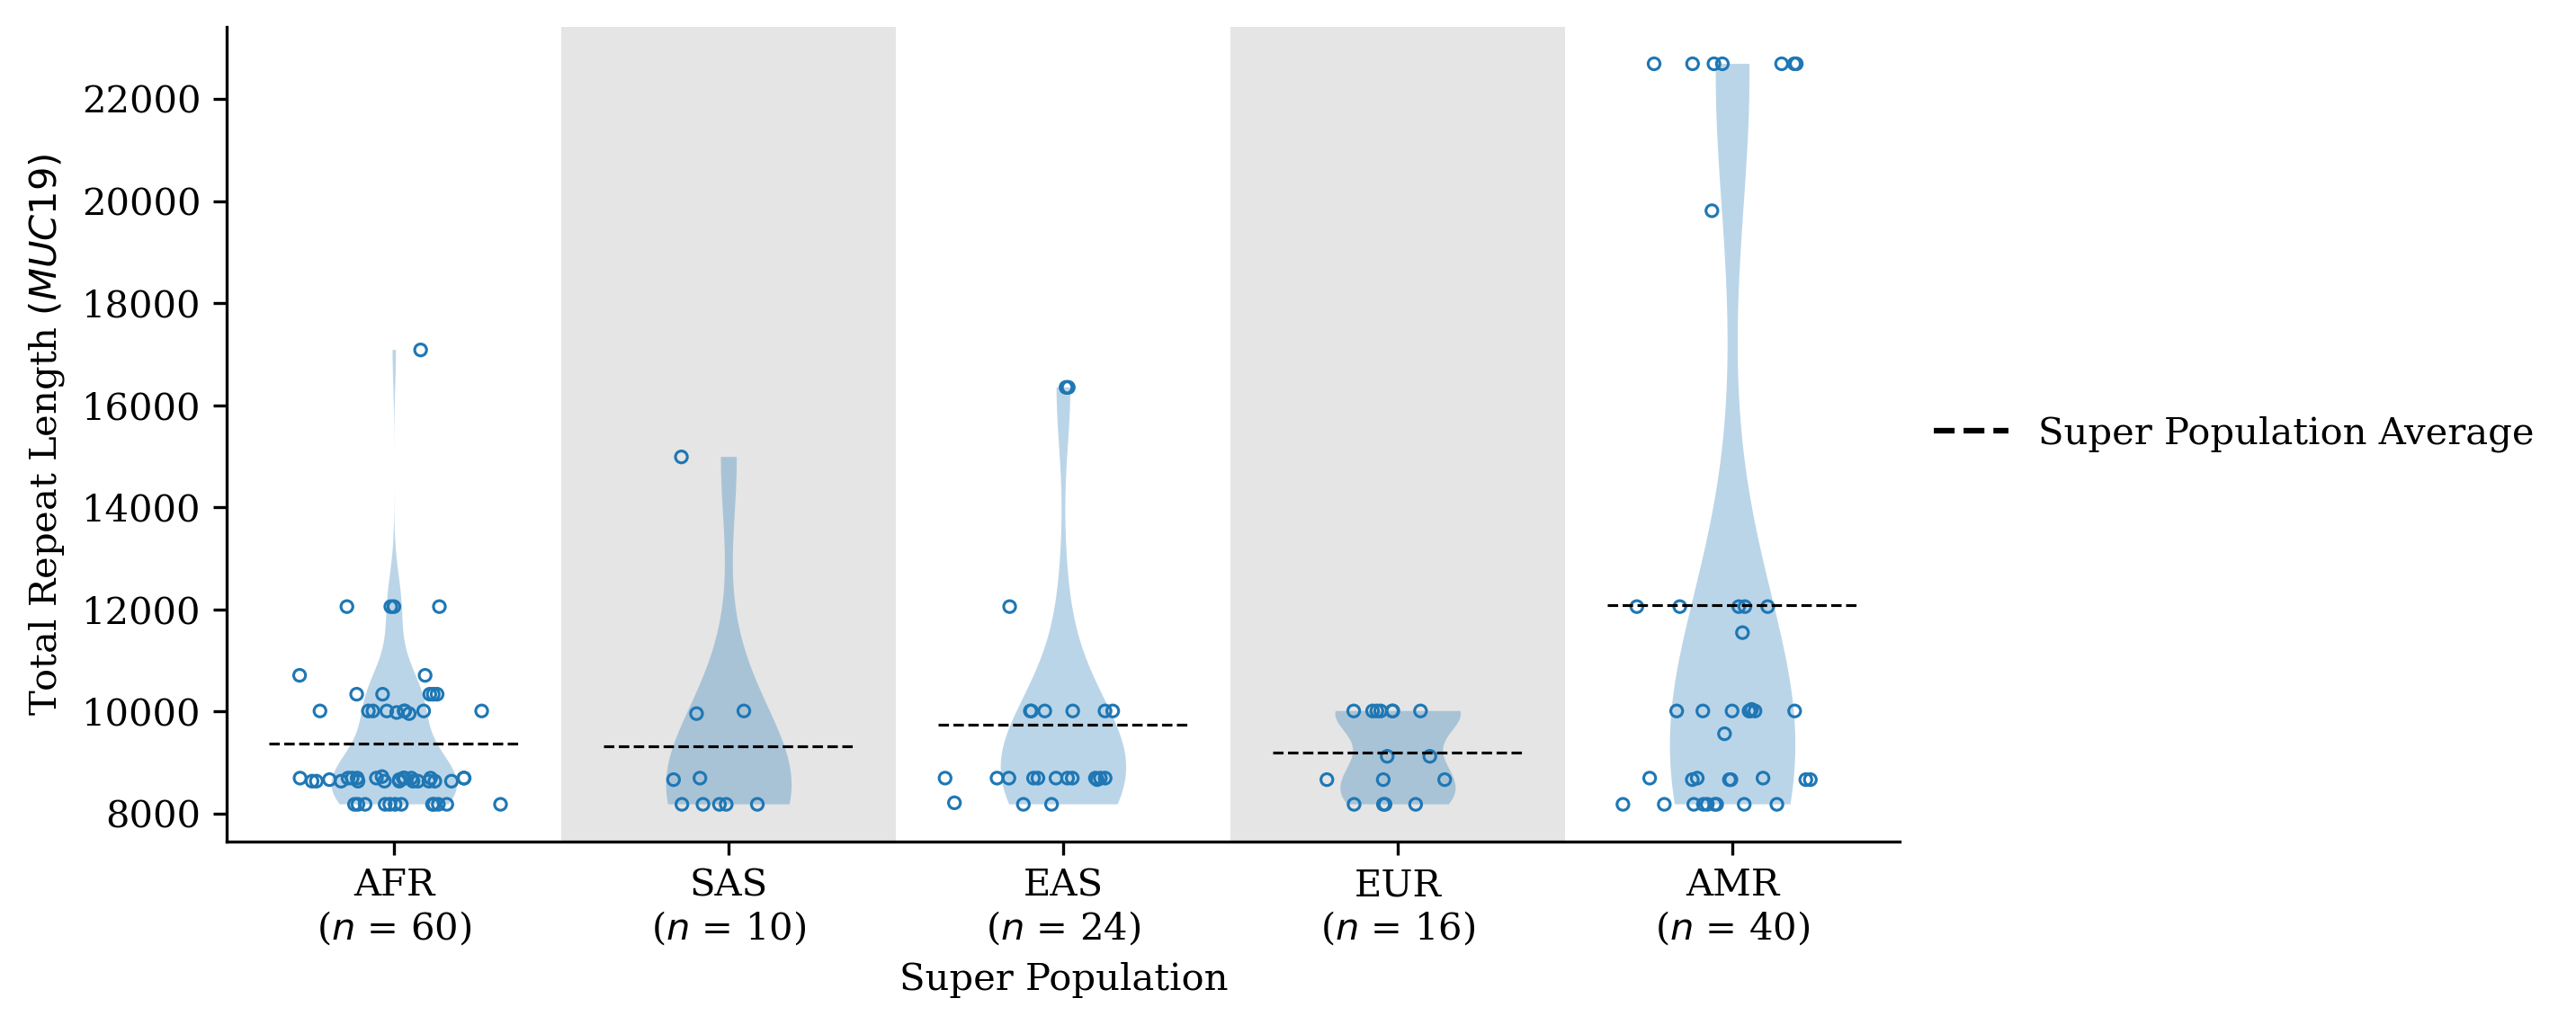

In [14]:
# Set the positions.
repeat_pos = np.arange(0, len(tgp_spop_list)*2, 2)
# Intialize a function for plotting the alternating background.
def alt_bands(ax=None):
    locs = np.arange(2, len(tgp_spop_list)*2, 4)
    for loc in locs:
        ax.axvspan(loc-1, loc+1, facecolor='black', alpha=0.1)
# Intialize the figure.
fig = plt.figure(
    figsize=(8, 4), dpi=300,
)
# Intialize the axes.
ax = fig.add_subplot(111)
alt_bands(ax)
# Intialize a list to store repeat counts.
spop_repeats_72kb = []
# For every population...
for idx, spop in enumerate(tgp_spop_list):
    # Extract the positions.
    x_pos = repeat_pos[idx]
    # Subset the dataframe.
    sub_df = lengths_df[lengths_df['Super Population'] == spop]
    # Append the repeat list.
    spop_repeats_72kb.append(sub_df['Total Repeat Length'].values)
    # Compute the mean.
    repeat_mean = np.nanmean(sub_df['Total Repeat Length'].values)
    # Plot the mean.
    ax.hlines(
        repeat_mean, x_pos-0.75, x_pos+0.75,
        colors='black', linestyle='dashed', linewidths=0.75,
    )
# Intialize a label list.
x_labels = []
# Plot the repeat distributions.
ax.violinplot(
    spop_repeats_72kb, repeat_pos,
    vert=True, showextrema=False,
    widths=0.75,
)
# For every x-axis tick.
for i, spop in enumerate(tgp_spop_list):
    # Subset the dataframe.
    sub_df = lengths_df[lengths_df['Super Population'] == spop]
    # Grab the data points.
    y = sub_df['Total Repeat Length'].values
    # Add some jitter to the x-axis.
    x = np.random.normal(repeat_pos[i], 0.25, size=y.size)
    # Plot the points!
    ax.scatter(
        x, y, color='tab:blue', marker='o',
        facecolor='none', s=10, linewidths=0.75,
    )
    # Construct a label.
    label = spop+'\n'+r'($n$ = '+f'{y.size})'
    x_labels.append(label)
# Configure the legend.
legend_elements = [
    Line2D([0], [0], color='black', linestyle='dashed', label='Super Population Average'),
]
# Add a figure lgend.
ax.legend(
    handles=legend_elements, loc='center left',
    bbox_to_anchor=(1.0, 0.5), frameon=False,
)
# Set the axes labels.
plt.xlabel('Super Population')
plt.ylabel(r'Total Repeat Length $\left( MUC19 \right)$')
# Set the x-axis tick positions and labels.
ax.set_xticks(repeat_pos)
ax.set_xticklabels(x_labels)
# Set the x-axis tick positions and labels.
ax.set_xlim(-1, (len(tgp_spop_list)*2)-1)
# Export the plot.
# plt.savefig(
#     f'./supp_figures/tgp_muc19_long_read_vntr_length_dist.png', format='png',
#     facecolor='white', bbox_inches='tight', dpi=500,
# )
# Show the plot.
plt.show()

## Short-Read vs Long-Read Data

In [15]:
# Read in the repeat count data for the samples that have short and long read data
long_v_short_df = pd.read_csv('../meta_data/hg38_muc19_long_vs_short_read_repeats.csv')

In [16]:
# Extract the short and long read counts.
long = long_v_short_df['Long Read Repeat Counts'].values
short = long_v_short_df['Short Read Repeat Counts'].values
# Run a correlation tests.
p_r, p_pval = stats.pearsonr(long, short)
s_r, s_pval = stats.spearmanr(long, short)

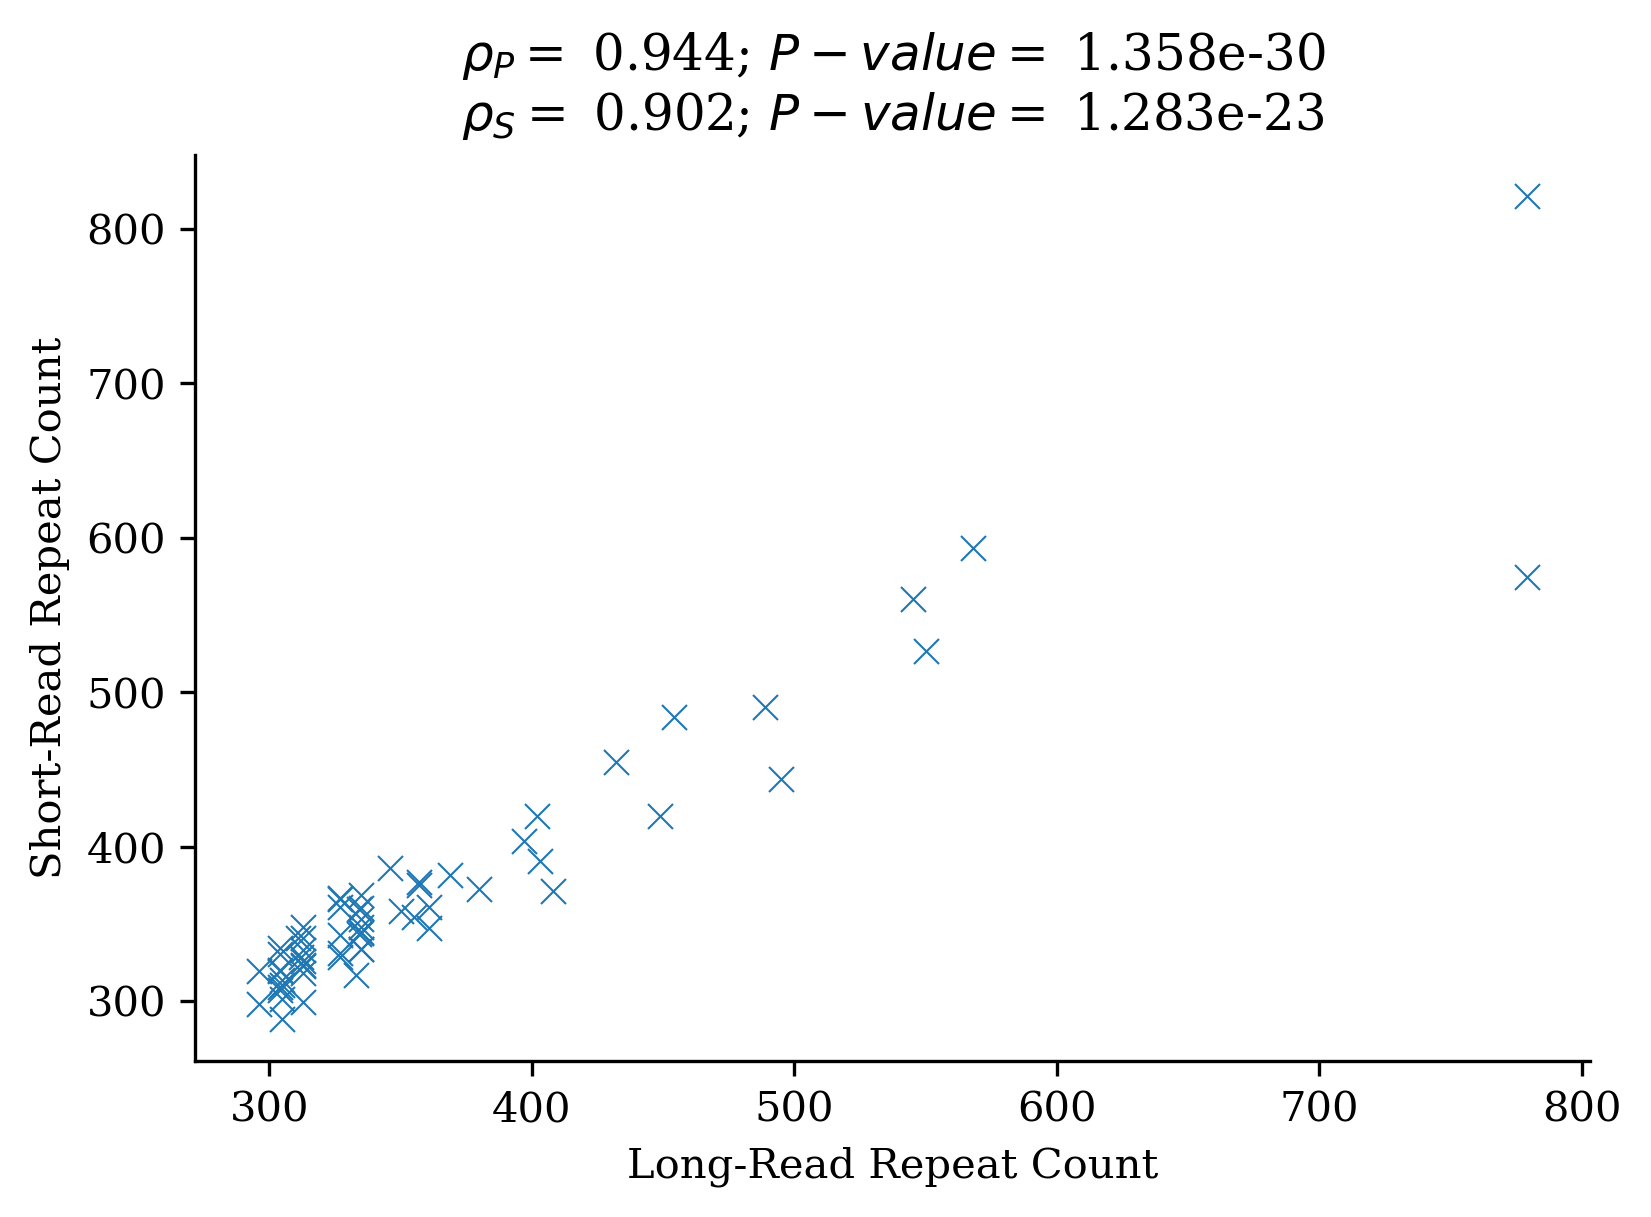

In [17]:
# Intialize the figure.
fig = plt.figure(
    figsize=(6, 4), dpi=300,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the long vs short reads.
ax.scatter(
    long, short, color='tab:blue',
    marker='x', linewidths=0.5,
)
# Add the axes labels.
ax.set_xlabel('Long-Read Repeat Count')
ax.set_ylabel('Short-Read Repeat Count')
# Construct the title.
rp = r'$\rho_{P} =$'+' {0}'.format(round(p_r, 3))
rpval = r'$P-value =$'+' {0}'.format('{:.3e}'.format(p_pval))
sp = r'$\rho_{S} =$'+' {0}'.format(round(s_r, 3))
spval = r'$P-value =$'+' {0}'.format('{:.3e}'.format(s_pval))
ax.set_title(rp+'; '+rpval+'\n'+sp+'; '+spval)
# Export the plot.
# plt.savefig(
#     f'./supp_figures/tgp_muc19_long_read_v_short_read_vntr_counts.png', format='png',
#     facecolor='white', bbox_inches='tight', dpi=500,
# )
# Show the plot.
plt.show()